In [ ]:
import pandas as pd              
import statsmodels.formula.api as smf 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import statistics as stats
from matplotlib.lines import Line2D
from pysal.lib import weights 
from esda import Moran
import numpy as np
from patsy import dmatrices
from spreg import OLS
from pysal.lib import weights 
from spreg import GM_Error_Het

# MAP
same chunk of the other ipynb file

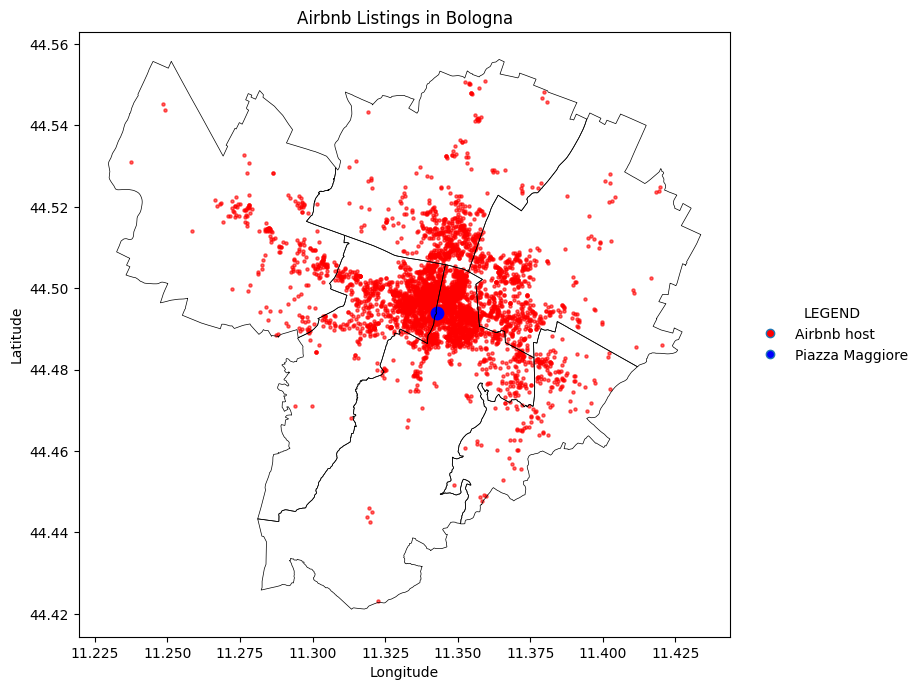

In [ ]:
path = "dataset/dataset.csv"
df = pd.read_csv(path)  

neigh = gpd.read_file("dataset/neighbourhoods.geojson")
gdf = gpd.GeoDataFrame(
    df.dropna(subset=["longitude","latitude"]),
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)
piazza = gpd.GeoDataFrame(geometry=[Point(11.3430, 44.4939)], crs="EPSG:4326")

metric_crs = "EPSG:32632"
gdf_m = gdf.to_crs(metric_crs)
piazza_m = piazza.to_crs(metric_crs).iloc[0].geometry

# Distanza in km
gdf["distance"] = gdf_m.geometry.distance(piazza_m) / 1000.0

# Plot
ax = neigh.boundary.plot(figsize=(9, 8), color="black", linewidth=0.5)
gdf.plot(ax=ax, color="red", markersize=5, alpha=0.6)
piazza.plot(ax=ax, color="blue", markersize=80)

# Legend
ax.legend(
    handles=[
        Line2D([0],[0], marker='o', linestyle='None', markerfacecolor='red', label='Airbnb host'),
        Line2D([0],[0], marker='o', linestyle='None', markerfacecolor='blue', label='Piazza Maggiore'),
    ],
    title="LEGEND", loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False
)

ax.set_title("Airbnb Listings in Bologna")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


# MORAN'S I - overview

In [40]:
w = weights.distance.KNN.from_dataframe(gdf, k=9) # 9 choosen after many attempts of not having isolated components
w.transform = "R"

mi = Moran(gdf["price"], w)

print("Moran's I:", mi.I)
print("p-value:", mi.p_norm)

Moran's I: 0.17576890680716992
p-value: 2.5470883416130774e-162


# OLS

In [ ]:

formula = (
    "price ~ distance + reviews "
    "+ C(room_type, Treatment(reference='Entire home/apt')) " # dummy
    "+ C(host_class, Treatment(reference='single'))" # dummy
)

ols = smf.ols(formula, data=gdf).fit()
print(ols.summary())

# for Moran's I
gdf["resid_ols"] = ols.resid  

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     64.78
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           1.99e-89
Time:                        21:42:49   Log-Likelihood:                -5466.9
No. Observations:                4668   AIC:                         1.095e+04
Df Residuals:                    4660   BIC:                         1.100e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

# MORAN on residuals 

In [42]:
mi_resid = Moran(gdf["resid_ols"], w)
print("Moran's I:", mi_resid.I)
print("p-value:", mi_resid.p_norm)

Moran's I: 0.14735655638375345
p-value: 9.857249802280445e-115


# LAGRANGE MULTIPLIER 

In [ ]:
y_mat, X_mat = dmatrices(formula, data=gdf, return_type="dataframe")
y = np.asarray(y_mat)         
X = np.asarray(X_mat)          
xnames = X_mat.design_info.column_names

ols_spreg = OLS(y, X, w=w, name_y="price", name_x=xnames, spat_diag=True, moran=True)
print(ols_spreg.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       price                Number of Observations:        4668
Mean dependent var  :      4.7335                Number of Variables   :           8
S.D. dependent var  :      0.8177                Degrees of Freedom    :        4660
R-squared           :      0.0887
Adjusted R-squared  :      0.0873
Sum squared residual:     2843.83                F-statistic           :     64.7841
Sigma-square        :       0.610                Prob(F-statistic)     :   1.995e-89
S.E. of regression  :       0.781                Log likelihood        :   -5466.924
Sigma-square ML     :       0.609                Akaike info criterion :   10949.849
S.E of regression ML:      0.7805                Schwarz criterion     :   11001.437

------------------------------------------------------------

# SEM 

In [48]:
sem = GM_Error_Het(y, X, w=w, name_y="price", name_x=xnames)
print(sem.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       price                Number of Observations:        4668
Mean dependent var  :      4.7335                Number of Variables   :           8
S.D. dependent var  :      0.8177                Degrees of Freedom    :        4660
Pseudo R-squared    :      0.0878
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         4.94905         0.03580       138.22391         0.00000
C(room_type, Treatment(reference='Entire home/apt'))[T.H

In [ ]:
# residual filtered by SEM
eps_hat = np.asarray(sem.e_filtered).ravel()   

mi_eps = Moran(eps_hat, w)
print("Moran I (residuals filtered):", round(mi_eps.I, 4), "p:", mi_eps.p_norm)


Moran I (residui filtrati): 0.0054 p: 0.3885904487258287
